In [2]:
import argparse
import cv2
import numpy as np
import torch
from d2l import torch as d2l
import pytorch_grad_cam
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, \
                            ScoreCAM, \
                            GradCAMPlusPlus, \
                            AblationCAM, \
                            XGradCAM, \
                            EigenCAM, \
                            EigenGradCAM, \
                            LayerCAM, \
                            FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit
import model as mod
import cv2
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models.resnet import resnet18

In [3]:
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [4]:
pthfile_Dino_resnet = './models/trained_models/net_params_604345505_lr0.0001_epoch60_Dino_Resnet50.pth'
pthfile_resnet = './models/trained_models/net_params_704177844_lr0.0001_epoch60_Resnet50.pth'
pthfile_Dino_Vit = './models/trained_models/net_params_643813538_lr0.0001_epoch40_Dino_vit.pth'
pthfile_Vit = './models/trained_models/net_params_391561151_lr0.0001_epoch40_vit.pth'

In [5]:
class GradCAM_resnet:
    def __init__(self, model: nn.Module, target_layer: str, size=(224, 224), num_cls=1000, mean=None, std=None) -> None:
        self.model = model
        self.model.eval()
        
        for param in self.model.features.parameters():
            param.requires_grad = True
        
        # register hook
        # 可以自己指定层名，没必要一定通过target_layer传递参数
        self.model.features.layer4
        self.model.features.layer4[1].register_forward_hook(self.__forward_hook)
        self.model.features.layer4[1].register_backward_hook(self.__backward_hook)
#         getattr(self.model, target_layer).register_forward_hook(self.__forward_hook)
#         getattr(self.model, target_layer).register_backward_hook(self.__backward_hook)

        self.size = size
        self.origin_size = None
        self.num_cls = num_cls

        self.mean, self.std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        if mean and std:
            self.mean, self.std = mean, std

        self.grads = []
        self.fmaps = []

    def forward(self, img_arr: np.ndarray, label=None, show=True, write=False):
        img_input = self.__img_preprocess(img_arr.copy())

        # forward
        output = self.model(img_input)
        idx = np.argmax(output.cpu().data.numpy())

        # backward
        self.model.zero_grad()
        loss = self.__compute_loss(output, label)

        loss.backward()

        # generate CAM
        grads_val = self.grads[0].cpu().data.numpy().squeeze()
        fmap = self.fmaps[0].cpu().data.numpy().squeeze()
        cam = self.__compute_cam(fmap, grads_val)
        
        # show
        cam_show = cv2.resize(cam, self.origin_size)
        img_show = img_arr.astype(np.float32) / 255
        self.__show_cam_on_image(img_show, cam_show, if_show=show, if_write=write)

        self.fmaps.clear()
        self.grads.clear()
        
    def __img_transform(self, img_arr: np.ndarray, transform: torchvision.transforms) -> torch.Tensor:
        img = img_arr.copy()  # [H, W, C]
        img = Image.fromarray(np.uint8(img))
        img = transform(img).unsqueeze(0)  # [N,C,H,W]
        return img

    def __img_preprocess(self, img_in: np.ndarray) -> torch.Tensor:
        self.origin_size = (img_in.shape[1], img_in.shape[0])  # [H, W, C]
        img = img_in.copy()
        img = cv2.resize(img, self.size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
        img_tensor = self.__img_transform(img, transform)
        return img_tensor

    def __backward_hook(self, module, grad_in, grad_out):
        self.grads.append(grad_out[0].detach())
    
    def __forward_hook(self, module, input, output):
        self.fmaps.append(output)

    def __compute_loss(self, logit, index=None):
        if not index:
            index = np.argmax(logit.cpu().data.numpy())
        else:
            index = np.array(index)

        index = index[np.newaxis, np.newaxis]
        index = torch.from_numpy(index)
        one_hot = torch.zeros(1, self.num_cls).scatter_(1, index, 1)
        one_hot.requires_grad = True
        loss = torch.sum(one_hot * logit)
        return loss
    
    def __compute_cam(self, feature_map, grads):
        """
        feature_map: np.array [C, H, W]
        grads: np.array, [C, H, W]
        return: np.array, [H, W]
        """
        cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
        alpha = np.mean(grads, axis=(1, 2))  # GAP
        for k, ak in enumerate(alpha):
            cam += ak * feature_map[k]  # linear combination
        
        cam = np.maximum(cam, 0)  # relu
        cam = cv2.resize(cam, self.size)
        cam = (cam - np.min(cam)) / np.max(cam)
        return cam


    def __show_cam_on_image(self, img: np.ndarray, mask: np.ndarray, if_show=True, if_write=False):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        if if_write:
            cv2.imwrite("camcam.jpg", cam)
        if if_show:
            plt.imshow(cam[:, :, ::-1])
            plt.show()



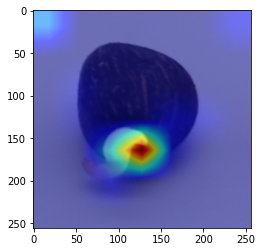

In [43]:
img = cv2.imread('./data/train/GoodSeed/goodtrain2.png', 1)
devices = d2l.try_all_gpus()
net = mod.get_ResNet_net(devices)
net_data = torch.load(pthfile_resnet)
net.load_state_dict(net_data)
net.eval()
net.to('cpu')
grad_cam = GradCAM_resnet(net, 'layer4', (224, 224),2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
grad_cam.forward(img, show=True, write=False)

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_dino_main


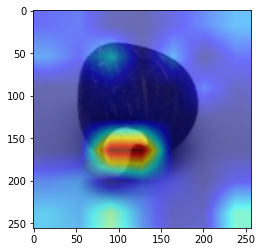

In [44]:
net = mod.get_Dino_net(devices)
net_data = torch.load(pthfile_Dino_resnet)
net.load_state_dict(net_data)
net.eval()
net.to('cpu')
grad_cam = GradCAM_resnet(net, 'layer4', (224, 224),2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
grad_cam.forward(img, show=True, write=False)

In [45]:
net = mod.get_Dino_Vit_net(devices)
net_data = torch.load(pthfile_Dino_Vit)
net.load_state_dict(net_data)
net.eval()
for param in net.features.parameters():
    param.requires_grad = True
net.to('cpu')
print()

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_dino_main


In [46]:
cam = GradCAM(model=net,
target_layers=[net.features.blocks[-1].norm1],
use_cuda=False,
reshape_transform=reshape_transform)

In [47]:
image_path = './data/train/GoodSeed/goodtrain22.png'
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])

In [48]:
targets = None
cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
visualization = show_cam_on_image(rgb_img, grayscale_cam)
cam_image = show_cam_on_image(rgb_img, grayscale_cam)

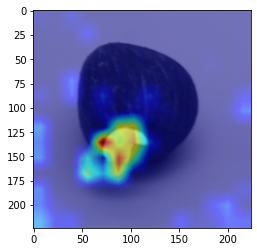

In [49]:
plt.imshow(cam_image[:, :, ::-1])
plt.show()

In [50]:
net = mod.get_Vit_net(devices)
net_data = torch.load(pthfile_Vit)
net.load_state_dict(net_data)
net.eval()
for param in net.features.parameters():
    param.requires_grad = True
net.to('cpu')
print()

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_deit_main


In [51]:
cam = GradCAM(model=net,
target_layers=[net.features.blocks[-1].norm1],
use_cuda=False,
reshape_transform=reshape_transform)

In [52]:
image_path = './data/train/GoodSeed/goodtrain22.png'
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])

In [53]:
targets = None
cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
visualization = show_cam_on_image(rgb_img, grayscale_cam)
cam_image = show_cam_on_image(rgb_img, grayscale_cam)

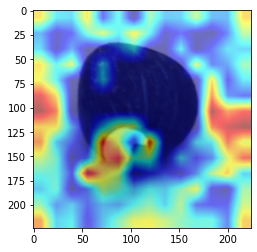

In [54]:
plt.imshow(cam_image[:, :, ::-1])
plt.show()

In [6]:
print("batch-2:")

batch-2:


D:\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


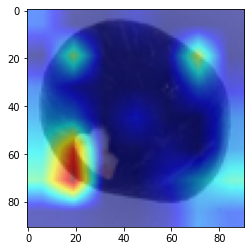

In [7]:
img = cv2.imread('./data/LightBox/saliency_map_test/test.png', 1)
devices = d2l.try_all_gpus()
net = mod.get_ResNet_net(devices)
net_data = torch.load(pthfile_resnet)
net.load_state_dict(net_data)
net.eval()
net.to('cpu')
grad_cam = GradCAM_resnet(net, 'layer4', (224, 224),2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
grad_cam.forward(img, show=True, write=False)

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_dino_main


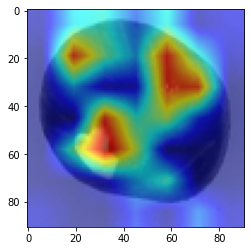

In [8]:
net = mod.get_Dino_net(devices)
net_data = torch.load(pthfile_Dino_resnet)
net.load_state_dict(net_data)
net.eval()
net.to('cpu')
grad_cam = GradCAM_resnet(net, 'layer4', (224, 224),2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
grad_cam.forward(img, show=True, write=False)

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_dino_main


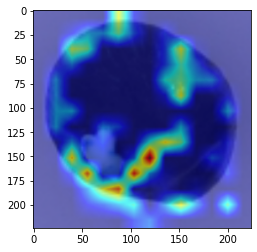

In [10]:
net = mod.get_Dino_Vit_net(devices)
net_data = torch.load(pthfile_Dino_Vit)
net.load_state_dict(net_data)
net.eval()
for param in net.features.parameters():
    param.requires_grad = True
net.to('cpu')
cam = GradCAM(model=net,
target_layers=[net.features.blocks[-1].norm1],
use_cuda=False,
reshape_transform=reshape_transform)
image_path = './data/LightBox/saliency_map_test/test.png'
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
targets = None
cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
visualization = show_cam_on_image(rgb_img, grayscale_cam)
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
plt.imshow(cam_image[:, :, ::-1])
plt.show()

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_deit_main


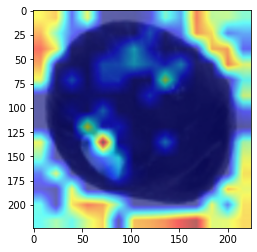

In [21]:
net = mod.get_Vit_net(devices)
net_data = torch.load(pthfile_Vit)
net.load_state_dict(net_data)
net.eval()
for param in net.features.parameters():
    param.requires_grad = True
net.to('cpu')
print()
cam = GradCAM(model=net,
target_layers=[net.features.blocks[-1].norm1],
use_cuda=False,
reshape_transform=reshape_transform)
image_path = './data/LightBox/saliency_map_test/test.png'
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
targets = None
cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
visualization = show_cam_on_image(rgb_img, grayscale_cam)
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
plt.imshow(cam_image[:, :, ::-1])
plt.show()

In [13]:
print("batch-3")

batch-3


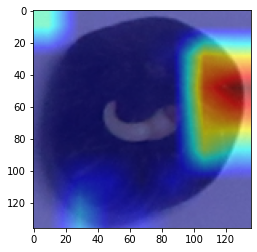

In [15]:
img = cv2.imread('./data/NormalRoomLighting/saliencymap_test/test.png', 1)
devices = d2l.try_all_gpus()
net = mod.get_ResNet_net(devices)
net_data = torch.load(pthfile_resnet)
net.load_state_dict(net_data)
net.eval()
net.to('cpu')
grad_cam = GradCAM_resnet(net, 'layer4', (224, 224),2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
grad_cam.forward(img, show=True, write=False)

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_dino_main


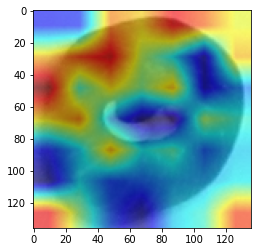

In [16]:
net = mod.get_Dino_net(devices)
net_data = torch.load(pthfile_Dino_resnet)
net.load_state_dict(net_data)
net.eval()
net.to('cpu')
grad_cam = GradCAM_resnet(net, 'layer4', (224, 224),2, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
grad_cam.forward(img, show=True, write=False)

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_dino_main


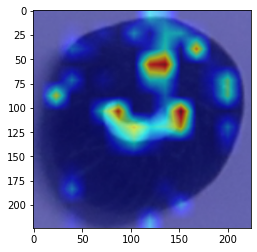

In [18]:
net = mod.get_Dino_Vit_net(devices)
net_data = torch.load(pthfile_Dino_Vit)
net.load_state_dict(net_data)
net.eval()
for param in net.features.parameters():
    param.requires_grad = True
net.to('cpu')
cam = GradCAM(model=net,
target_layers=[net.features.blocks[-1].norm1],
use_cuda=False,
reshape_transform=reshape_transform)
image_path = './data/NormalRoomLighting/saliencymap_test/test.png'
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
targets = None
cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
visualization = show_cam_on_image(rgb_img, grayscale_cam)
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
plt.imshow(cam_image[:, :, ::-1])
plt.show()

Using cache found in C:\Users\Ivan/.cache\torch\hub\facebookresearch_deit_main


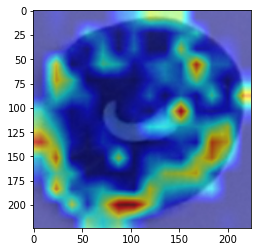

In [20]:
net = mod.get_Vit_net(devices)
net_data = torch.load(pthfile_Vit)
net.load_state_dict(net_data)
net.eval()
for param in net.features.parameters():
    param.requires_grad = True
net.to('cpu')
print()
cam = GradCAM(model=net,
target_layers=[net.features.blocks[-1].norm1],
use_cuda=False,
reshape_transform=reshape_transform)
image_path = './data/NormalRoomLighting/saliencymap_test/test.png'
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
targets = None
cam.batch_size = 32
grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
visualization = show_cam_on_image(rgb_img, grayscale_cam)
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
plt.imshow(cam_image[:, :, ::-1])
plt.show()